In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, Activation, Add, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils import class_weight
from itertools import cycle
import os

# --- CONFIGURATION ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
N_CLASSES = 4

# Setup Paths (Ensure these match your folder structure)
train_dir = 'data/train'
validation_dir = 'data/validation'
test_dir = 'data/test'

2025-11-29 15:32:05.333043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# --- FIX: UPDATE DATA GENERATORS WITH VGG PREPROCESSING ---
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1. Update Generators to use 'preprocess_input' instead of 'rescale'
# This ensures the images perfectly match what the frozen VGG weights expect.

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # <--- KEY CHANGE
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation/Test should also use the exact same preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # <--- KEY CHANGE

# 2. Re-load the iterators
print("Reloading Data with Correct Preprocessing...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    color_mode='rgb'
)

Reloading Data with Correct Preprocessing...
Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [3]:
# --- CUSTOM RESIDUAL BLOCK (The Algorithmic Change) ---
def residual_block(input_tensor, filters):
    """
    Creates a residual block with a skip connection.
    Input -> [Conv -> BN -> ReLU -> Conv -> BN] + Input -> ReLU
    """
    x = input_tensor
    
    # 1. Convolutional Path (F(x))
    fx = Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    fx = BatchNormalization()(fx)
    
    fx = Conv2D(filters, (3, 3), padding='same')(fx)
    fx = BatchNormalization()(fx)
    
    # 2. Skip Connection (x)
    # Adding the input directly to the output allows gradients to flow 
    # more easily, helping the model learn complex features for 'glioma'.
    x = Add()([x, fx])
    
    # 3. Final Activation
    x = Activation('relu')(x)
    return x

In [4]:
# --- CALCULATE CLASS WEIGHTS ---
# Get all labels from the training generator
y_train_labels = train_generator.classes

# Compute weights: higher weight for under-represented classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
# Convert to dictionary format required by Keras
class_weights_dict = dict(enumerate(class_weights))

print(f"\nComputed Class Weights: {class_weights_dict}")


Computed Class Weights: {0: np.float64(0.8687594553706506), 1: np.float64(0.8727203647416414), 2: np.float64(1.817246835443038), 3: np.float64(0.8674471299093656)}


In [5]:
# --- BUILD NOVEL HYBRID ARCHITECTURE (FIXED) ---

# 1. Load VGG16 Base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# 2. Truncate VGG16
vgg_output = base_model.get_layer('block4_pool').output

# 3. Add Custom Layers
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(vgg_output)

# --- Inject Residual Blocks ---
x = residual_block(x, filters=512)
x = residual_block(x, filters=512)

# --- THE FIX: NORMALIZE BEFORE FLATTENING ---
# This scales the high-value VGG features down so the Dense layers can learn
x = BatchNormalization(name='adapter_bn')(x) 

# 4. Add Custom Classification Head
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(N_CLASSES, activation='softmax')(x)

# 5. Final Model Assembly
model = Model(inputs=base_model.input, outputs=predictions)

print("\n--- Novel VGG16-ResNet Hybrid Model Summary (Fixed) ---")
# model.summary() # Optional: Uncomment to see structure

I0000 00:00:1764448328.420561 1405239 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



--- Novel VGG16-ResNet Hybrid Model Summary (Fixed) ---


In [6]:
# --- STAGE 1: TRAIN TOP LAYERS ---
print("\n--- Starting Stage 1: Training Custom Layers ---")
# Reduced LR from 0.001 to 0.0001 to prevent 'shocking' the weights
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history_stage1 = model.fit(
    train_generator,
    epochs=50,  # 30 epochs is enough for Stage 1
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict
)

# --- STAGE 2: FINE-TUNING ---
print("\n--- Starting Stage 2: Fine-Tuning Hybrid Architecture ---")

# Unfreeze block4 (Index 11)
for layer in base_model.layers[11:]:
    layer.trainable = True

# Very low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_stage2 = model.fit(
    train_generator,
    epochs=50, 
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weights_dict
)


--- Starting Stage 1: Training Custom Layers ---


/home/mandar-dhamale/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-11-29 15:32:12.493690: I external/local_xla/xla/service/service.cc:163] XLA service 0x7673f801c870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-29 15:32:12.493722: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-11-29 15:32:12.575006: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-29 15:32:13.090610: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


  2/143 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.1719 - loss: 3.7596

I0000 00:00:1764448341.463339 1405436 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - accuracy: 0.5769 - loss: 1.1765 - val_accuracy: 0.8143 - val_loss: 0.4649
Epoch 2/50
  1/143 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - accuracy: 0.5625 - loss: 0.7179

/home/mandar-dhamale/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5625 - loss: 0.7179 - val_accuracy: 0.8286 - val_loss: 0.4516
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 164ms/step - accuracy: 0.7343 - loss: 0.6567 - val_accuracy: 0.8304 - val_loss: 0.4584
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6250 - loss: 0.8500 - val_accuracy: 0.8143 - val_loss: 0.4629
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 159ms/step - accuracy: 0.7918 - loss: 0.5120 - val_accuracy: 0.8964 - val_loss: 0.3062
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6875 - loss: 0.5640 - val_accuracy: 0.8857 - val_loss: 0.3161
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.8220 - loss: 0.4697 - val_accuracy: 0.9000 - val_loss: 0.2643
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 1.0000 - loss: 0.2048 - val_accuracy: 0.8982 - val_loss: 0.2590
Epoch 9/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.8413 - loss: 0.3952 - val_accurac

In [9]:
# --- 6. EVALUATE THE NOVEL MODEL ---

print("\n--- Evaluating the Novel Hybrid Model on the Test Set ---")
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Final Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

# --- GENERATE PREDICTIONS ---
# Reset generator to ensure order matches
test_generator.reset() 
test_steps = int(np.ceil(test_generator.samples / BATCH_SIZE))

# Get probabilities for all classes
Y_pred_probs = model.predict(test_generator, steps=test_steps)

# Convert probabilities to class labels (0, 1, 2, 3)
y_pred_labels = np.argmax(Y_pred_probs, axis=1)

# Get true labels
y_true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- CLASSIFICATION REPORT ---
print("\n--- Novel Model Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))


--- Evaluating the Novel Hybrid Model on the Test Set ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.7995 - loss: 2.5187
Final Test Accuracy: 79.95%
Final Test Loss: 2.5187
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step

--- Novel Model Classification Report ---
              precision    recall  f1-score   support

      glioma       0.97      0.28      0.43       100
  meningioma       0.71      0.98      0.82       115
    no_tumor       0.78      1.00      0.88       105
   pituitary       1.00      0.96      0.98        74

    accuracy                           0.80       394
   macro avg       0.86      0.81      0.78       394
weighted avg       0.85      0.80      0.77       394



Generating predictions...
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step

--- Final Test Performance Metrics ---
Final Test Accuracy: 80.46%
Final Test Loss: 2.4548

--- Detailed Classification Report ---
              precision    recall  f1-score   support

      glioma       0.97      0.28      0.43       100
  meningioma       0.71      0.98      0.82       115
    no_tumor       0.78      1.00      0.88       105
   pituitary       1.00      0.96      0.98        74

    accuracy                           0.80       394
   macro avg       0.86      0.81      0.78       394
weighted avg       0.85      0.80      0.77       394


--- Generating Confusion Matrix ---


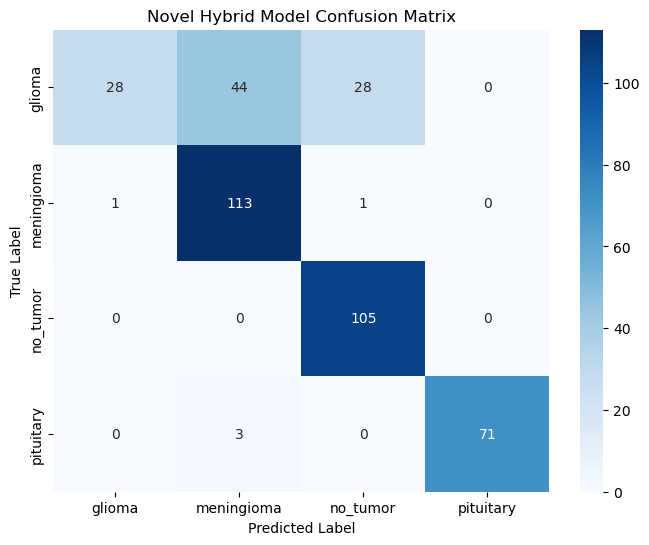


--- Generating AUC-ROC Curves ---


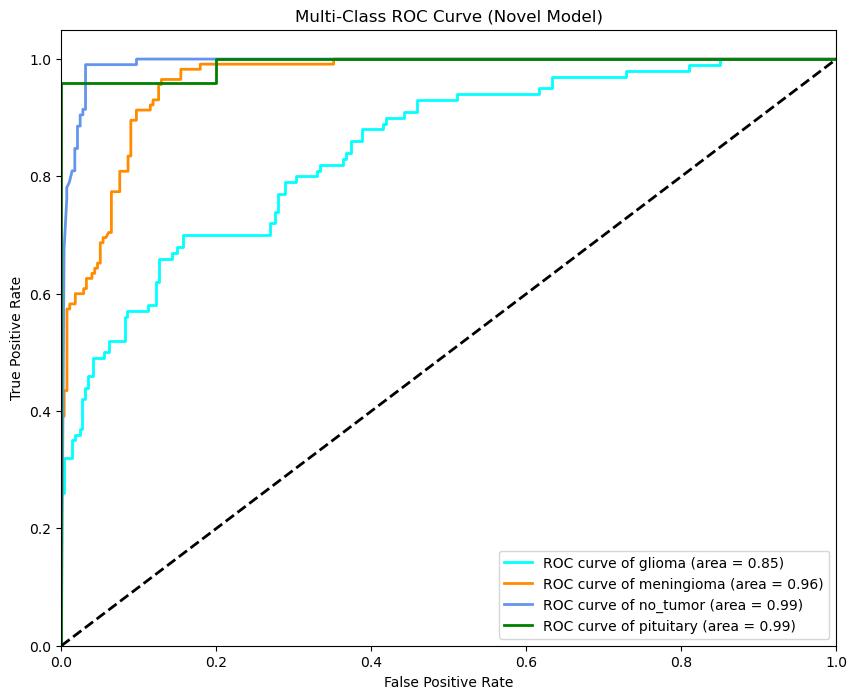


--- Generating Precision-Recall Curves ---


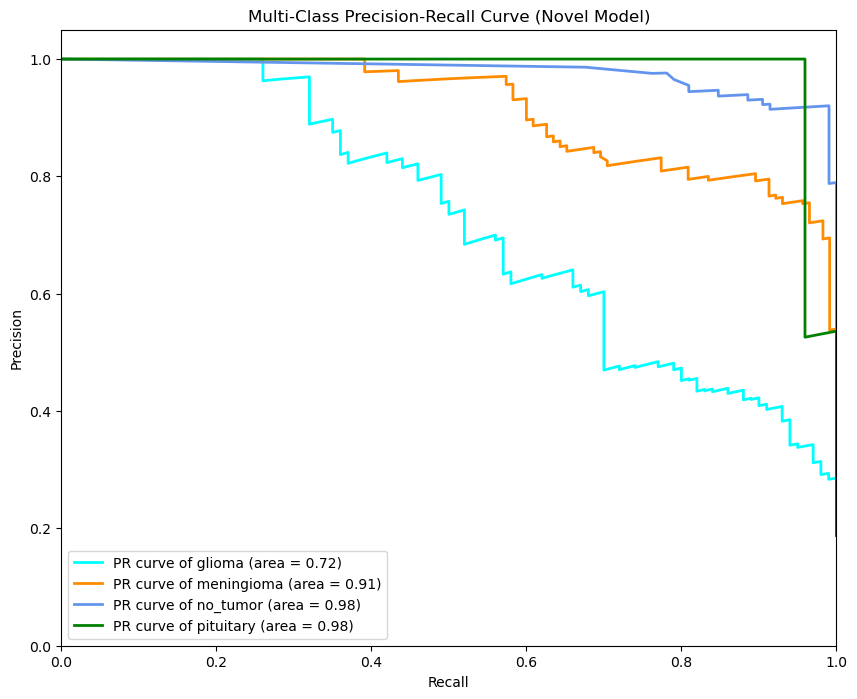

In [11]:
# --- 1. GENERATE PREDICTIONS ---
print("Generating predictions...")
# Reset the test generator to ensure the order of images matches the order of predictions
test_generator.reset()

# Get the true labels (from the dataset)
y_true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Get model predictions (raw probabilities)
# steps needs to cover the whole test set
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
Y_pred_probs = model.predict(test_generator, steps=steps)

# Convert probabilities to class indices (0, 1, 2, 3)
y_pred_labels = np.argmax(Y_pred_probs, axis=1)

# --- 2. PRINT PERFORMANCE METRICS ---
print("\n--- Final Test Performance Metrics ---")
# Calculate Loss and Accuracy
loss, accuracy = model.evaluate(test_generator, steps=steps, verbose=0)
print(f"Final Test Accuracy: {accuracy*100:.2f}%")
print(f"Final Test Loss: {loss:.4f}")

print("\n--- Detailed Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

# --- 3. PLOT CONFUSION MATRIX ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Novel Hybrid Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 4. PLOT ROC CURVES ---
print("\n--- Generating AUC-ROC Curves ---")
# One-hot encode true labels for ROC calculation
y_true_one_hot = tf.keras.utils.to_categorical(y_true_labels, num_classes=N_CLASSES)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

for i, color in zip(range(N_CLASSES), colors):
    # Calculate ROC for each class
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_labels[i]} (area = {roc_auc[i]:0.2f})')

# Plot the "Random Guess" line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Novel Model)')
plt.legend(loc="lower right")
plt.show()

# --- 5. PLOT PRECISION-RECALL CURVES ---
print("\n--- Generating Precision-Recall Curves ---")
precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(10, 8))

for i, color in zip(range(N_CLASSES), colors):
    # Calculate Precision-Recall for each class
    precision[i], recall[i], _ = precision_recall_curve(y_true_one_hot[:, i], Y_pred_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])
    
    # Plot
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PR curve of {class_labels[i]} (area = {pr_auc[i]:0.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curve (Novel Model)')
plt.legend(loc="lower left")
plt.show()